# Twitter Sentiment Analysis for Apple

## Table of Contents: 
### 1. Data Exploration and Cleaning
### 2. Data Analysis 
### 3. Modeling 
### 4. Recommendations
### 5. Conclusion

## Introduction: 
Our team was tasked with performing sentiment analysis on a dataset of real tweets gathered from the South by Southwest Conference in Austin, Texas in 2012. First, we preprocessed the tweets through tokenization, lemmatization, and the use of stop words. We then separated the tweets by their labeled emotion, either 'Positive' or 'Negative', in order to create a binary classification target. We first analyze overall positive and negative sentiment by creating frequency distributions and word clouds in order to visualize the most significant words. Then, we dig further into the data by analyzing tweets based on which Apple product they reference. Because we find that the iPhone received the most negative sentiment, we perform further analysis and visualization to uncover what causes users to tweet about the iPhone in a positive or negative context. Finally, we build, train, and assess both a Random Forest Classifier and an XGBoost Classifier. 

In [1]:
#import libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from wordcloud import WordCloud


In [2]:
#read in dataset as pandas dataframe
df = pd.read_csv("judge-1377884607_tweet_product_company.csv", encoding='latin1')

# Data Exploration and Cleaning

Our original dataset contains about 9,000 tweets from 2012 using the SXSW hashtag, all regarding either Apple or Google. The tweets have been previously hand-labelled as positive, negative, neutral, or unknown sentiment. For the purposes of our project, we will look at specifically Apple-related tweets, and only those that have been labelled as 'Positive' or 'Negative'. 

In [3]:
#set display options to see full text data
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### Filter tweets to only Apple-focused with Positive or Negative Sentiment

In [5]:
#create a function to determine whether a tweet refers to Apple or Google 
def company(product):
    apple_prods = ['ipad', 'apple', 'iphone']
    google_prods = ['google', 'other google product or service', 'android app', 'android']
    if any(item in str(product).lower() for item in apple_prods):
        return 'Apple'
    elif any(item in str(product).lower() for item in google_prods):
        return 'Google'
    else:
        return 'Unknown'

#apply function to create new column
df['Company'] = df['emotion_in_tweet_is_directed_at'].apply(lambda x: company(x))


In [6]:
#drop Google tweets
df = df[df['Company'] != 'Google']
#drop tweets with no emotion
desired_emotions = ['Positive emotion', 'Negative emotion']
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(desired_emotions)]

In [7]:
# Impute missing values in subject column
def find_product(tweet):
    tweet = str(tweet).lower()
    product = None
    if ' app' in tweet: 
        product = 'iPad or iPhone App'
    elif 'ipad' in tweet: 
        product = 'iPad'
    elif 'iphone' in tweet:
        product = 'iPhone'
    elif 'apple' in tweet:
        product_list = 'Apple'
    return product

#apply function to null values 
mask = df['emotion_in_tweet_is_directed_at'].isnull()
df.loc[mask, 'emotion_in_tweet_is_directed_at'] = df.loc[mask, 'tweet_text'].apply(find_product)

In [8]:
df[df['emotion_in_tweet_is_directed_at'].isna()].head(5)
#tweets remaining without a subject appear to be Google-related, so we can drop these too.
df.dropna(subset='emotion_in_tweet_is_directed_at', inplace=True)

In [9]:
#drop company column
df.drop('Company', axis=1, inplace=True)
#simplify column names
df.columns = ['Text', 'Subject', 'Emotion']

In [10]:
#clean emotion column
df['Emotion'] = df['Emotion'].apply(lambda x: x.split(' ')[0])

In [11]:
#look at split of our data
df['Emotion'].value_counts()

Positive    2141
Negative     419
Name: Emotion, dtype: int64

After cleaning our data, we find that our target class is very imbalanced. We will have to address this before our modelling process. But first, we will explore the distribution of words in our cleaned dataset. 

# Data Pre-Processing

### Create a pre-processing function to tokenize, remove stop words, and lemmatize

In [12]:

#define our preprocessing function
def text_preprocessing(tweet):
    tweet_cleaned = re.sub(r'@\w+', '', tweet)
    tweet_cleaned = re.sub(r'http://\S+', '', tweet_cleaned)
    pattern = "([a-zA-Z\d]+(?:'[a-z\d]+)?)"
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(tweet_cleaned)
    stop_words_list = stopwords.words('english')
    stop_words_list += ['sxsw', 'link', 'rt', 'quot', 'W', 'ipad', 'apple', 'iphone', 'austin', 'app', 'ipad2', 'u', '2', '3g', 'amp']
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words_list]
    lemmatizer = WordNetLemmatizer()
    lemmed_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmed_tokens


In [13]:
#test on one tweet
tester = df['Text'][19]
test_tokens = text_preprocessing(tester)
print(tester)
print(test_tokens)

Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV
['must', 'lovely', 'review', 'forbes', 'holler', 'gram']


### Apply the pre-processing function to our dataframe

In [14]:
df['Tokens'] = df['Text'].apply(text_preprocessing)

In [15]:
#sanity check
df.head(10)

,Text,Subject,Emotion,Tokens
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"[3, hr, tweeting, rise, dead, need, upgrade, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[know, awesome, likely, appreciate, design, also, they're, giving, free, t]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"[hope, year's, festival, crashy, year's]"
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive,"[beautifully, smart, simple, idea, wrote, hollergram]"
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive,"[counting, day, plus, strong, canadian, dollar, mean, stock, gear]"
14,Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l,iPad or iPhone App,Positive,[great]
15,"haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw",iPad or iPhone App,Positive,"[haha, awesomely, rad, hollergram]"
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative,"[noticed, dst, coming, weekend, many, user, hour, late, come, sunday, morning]"
18,"Just added my #SXSW flights to @planely. Matching people on planes/airports. Also downloaded the @KLM iPhone app, nicely done.",iPad or iPhone App,Positive,"[added, flight, matching, people, plane, airport, also, downloaded, nicely, done]"


In [16]:
#convert to lemmed token format
def format_lem(tokens):
    return ' '.join(tokens)

df['Formatted_Lemmed_Text'] = df['Tokens'].apply(format_lem)

### Explore Token Distribution and Frequency

In [17]:
#create a set of unique tokens 
token_set = []
for tokens in df['Tokens'].values:
    for token in tokens: 
        token_set.append(token)

len(set((token_set)))

4358

Our cleaned dataset includes 4,358 unique tokens. We will likely have to further filter before trainging our models on the data. 

### Explore Tweet Sentiment by Individual Products

In [18]:
df_by_product = df.groupby(['Subject'])['Text'].count().reset_index(name='count_of_tweets')
df_by_product['negative_count'] = [95, 2, 135, 76, 111]
df_by_product['percentage_negative'] = df_by_product['negative_count'] / df_by_product['count_of_tweets']

#create smaller, cleaner dataframe for visualizing purposes
df_plot = df_by_product[['Subject', 'percentage_negative']]
name_dict = {'Apple':'Apple', 'Other Apple product or service':'Other', 'iPad':'iPad', 'iPad or iPhone App':'Apps', 'iPhone': 'iPhone'}
df_plot['Subject'] = df_plot['Subject'].map(name_dict)


/var/folders/qh/ns54bt951q74xt4l68nw_m840000gn/T/ipykernel_44996/412583537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Subject'] = df_plot['Subject'].map(name_dict)


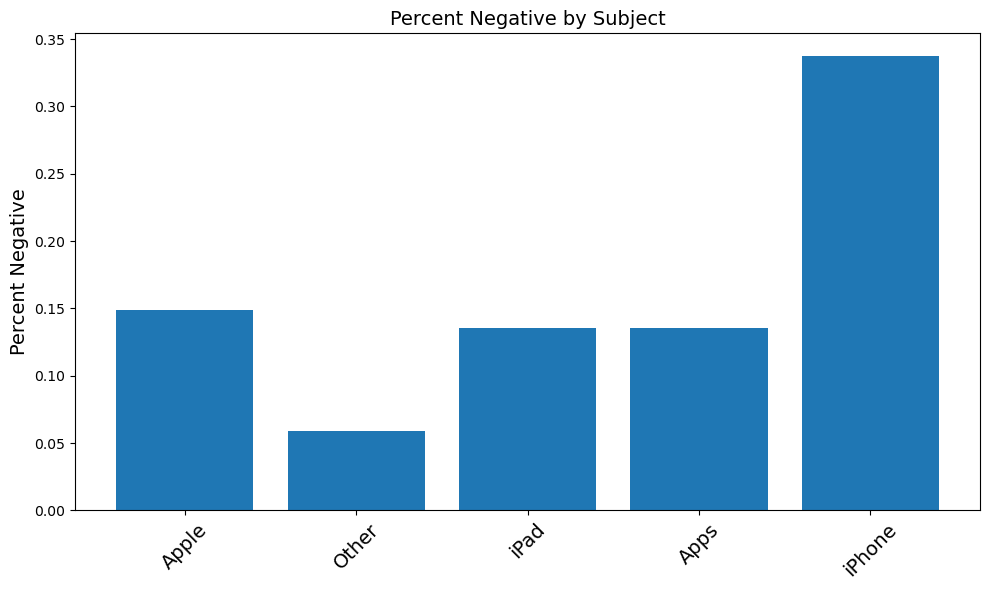

In [19]:
#explore sentiment ratios per product
plt.figure(figsize=(10, 6))  
plt.bar(df_plot['Subject'], df_plot['percentage_negative'])
plt.ylabel('Percent Negative', fontsize=14)
plt.title('Percent Negative by Subject', fontsize=14)
plt.xticks(rotation=45, fontsize=14)  
plt.tight_layout()  
plt.show()

## Visualize Tokens with Frequency Dsitribution and Word Clouds

In [20]:
#Create Frequency Distributions for both Positive and Negative Tweets
df_pos = df[df['Emotion'] == 'Positive']
positive_tokens = [token for tokens in df_pos['Tokens'].values for token in tokens]
pos_freq_dist = FreqDist(positive_tokens)

df_neg = df[df['Emotion'] == 'Negative']
negative_tokens = [token for tokens in df_neg['Tokens'].values for token in tokens]
neg_freq_dist = FreqDist(negative_tokens)

pos_freq_dist.most_common(20)
neg_freq_dist.most_common(20)


[('store', 47),
 ('like', 36),
 ('design', 29),
 ('apps', 25),
 ('people', 24),
 ('need', 22),
 ('line', 22),
 ('new', 22),
 ('one', 20),
 ('news', 18),
 ('think', 18),
 ('get', 18),
 ('look', 18),
 ('headache', 17),
 ('battery', 17),
 ('pop', 17),
 ('would', 17),
 ('time', 17),
 ('day', 17),
 ('say', 16)]

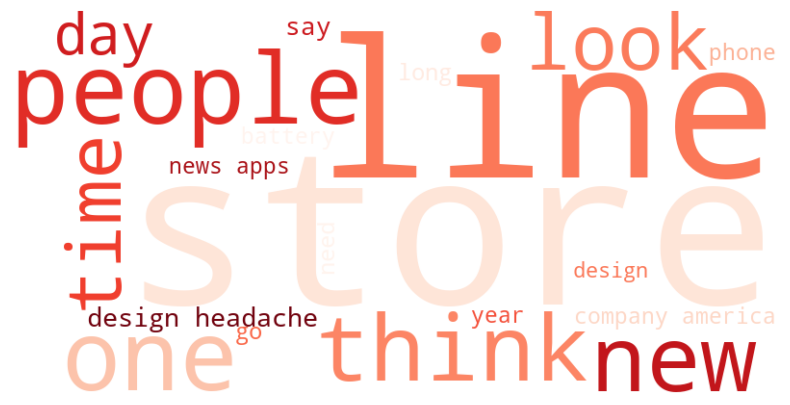

In [21]:
#create word cloud for all negative tweets
neg_string = ' '.join(negative_tokens)
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=20)
wc_neg.generate(neg_string)

plt.figure(figsize=(10, 5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.imshow;

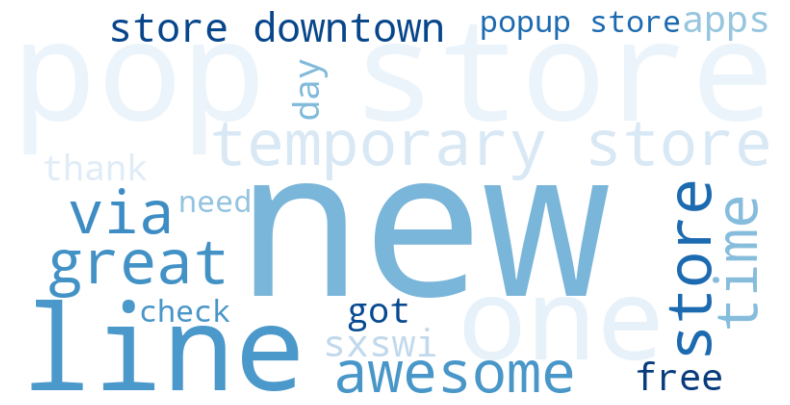

In [22]:
#Create a positive tweet word cloud 
pos_string = ' '.join(positive_tokens)
pos_wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues', max_words=20)
pos_wc.generate(pos_string)

plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.imshow;

In [23]:
#Look at tweets specifically regarding iPhone
df_iphone_neg = df[(df['Subject'] == 'iPhone') & (df['Emotion'] == 'Negative')]
iphone_neg_tokens = [token for tokens in df_iphone_neg['Tokens'].values for token in tokens]
iphone_neg_freq_dist = FreqDist(iphone_neg_tokens)
iphone_neg_freq_dist.most_common()

[('battery', 16),
 ('time', 9),
 ('blackberry', 8),
 ('go', 8),
 ('know', 7),
 ('already', 7),
 ('phone', 7),
 ('user', 6),
 ('going', 6),
 ('like', 6),
 ('many', 5),
 ('hour', 5),
 ('say', 5),
 ('people', 5),
 ('one', 5),
 ('think', 5),
 ('would', 5),
 ('life', 5),
 ('good', 5),
 ('3', 4),
 ('need', 4),
 ('android', 4),
 ("i'm", 4),
 ('panel', 4),
 ('back', 4),
 ('4', 4),
 ('mobile', 4),
 ('store', 4),
 ('shit', 4),
 ('last', 4),
 ('long', 4),
 ('made', 4),
 ('technology', 4),
 ('always', 4),
 ('fail', 4),
 ('working', 4),
 ('new', 4),
 ('get', 4),
 ('anything', 4),
 ('forward', 4),
 ('tweeting', 3),
 ('dead', 3),
 ('late', 3),
 ('come', 3),
 ('alarm', 3),
 ('flight', 3),
 ('also', 3),
 ('stupid', 3),
 ('even', 3),
 ("can't", 3),
 ('tweet', 3),
 ('getting', 3),
 ('brick', 3),
 ('help', 3),
 ('ever', 3),
 ('never', 3),
 ('could', 3),
 ('much', 3),
 ("iphone's", 3),
 ('useful', 3),
 ('ppl', 3),
 ('charge', 3),
 ('fix', 3),
 ('job', 3),
 ('thing', 3),
 ('put', 3),
 ('away', 3),
 ('party'

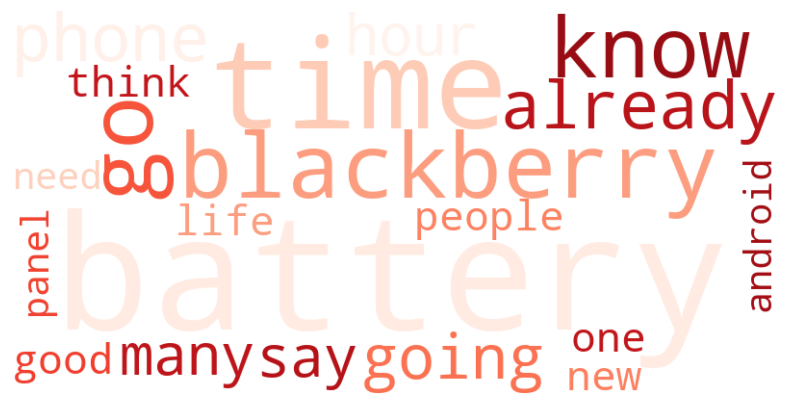

In [24]:
#create a negative iPhone word cloud
iphone_neg_string = " ".join(iphone_neg_tokens)
iphone_neg_wc = WordCloud(width=800, height=400, max_words=20, colormap='Reds', background_color='white')
iphone_neg_wc.generate_from_text(iphone_neg_string)

plt.figure(figsize=(10, 5))
plt.imshow(iphone_neg_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

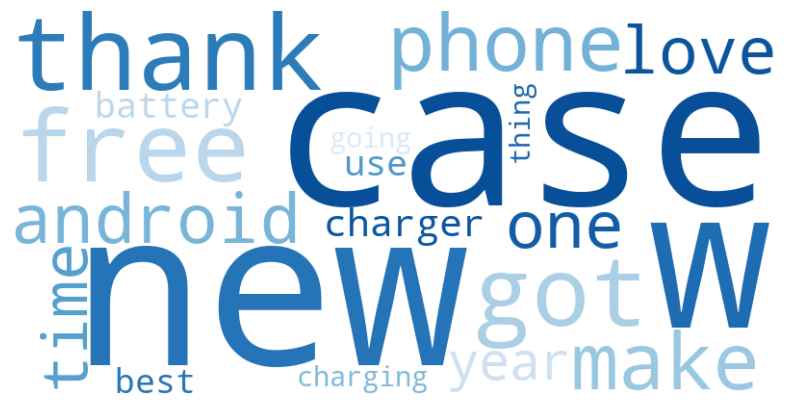

In [25]:
#create a positive iPhone word cloud
df_iphone_pos = df[(df['Subject'] == 'iPhone') & (df['Emotion'] == 'Positive')]
iphone_pos_tokens = [token for tokens in df_iphone_pos['Tokens'].values for token in tokens]
iphone_pos_string = " ".join(iphone_pos_tokens)
iphone_pos_wc = WordCloud(width=800, height=400, max_words=20, colormap='Blues', background_color='white')
iphone_pos_wc.generate_from_text(iphone_pos_string)

plt.figure(figsize=(10, 5))
plt.imshow(iphone_pos_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Modeling

## supplement data with additional negative tweets from Chat-GPT 
(Our goal is at least 70-30 split)

In [26]:
#get samples to train Chat-GPT on 
sample = df[df['Emotion'] == 'Negative'].sample(n = 10)
sample['Text'].values

array(['Mad mad lines still at the #SXSW Apple pop up store here in Austin #ipad2',
       "What Apple hopes you didn't notice about iPad 2 {link} #sxsw #sxswi #technology #mobile #prodmktg",
       'What a dissapointment!!! RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by (cont\x89Û_',
       '&quot;The Apple store at the mall on Sunday is 10x as crowded as this. This line is fake. I just need a fucking dongle.&quot; Genius let me in. #sxsw',
       "Fest tip-don't be an iPhone douche.Put away your phone and talk to your fellow festgoers in lines, etc.All good people who love film. #sxsw",
       'Guy Kawasaki &quot;I believe in God because there is no other explanation for the continuous survival of Apple over the years.&quot;. LOL #SXSW',
       'How frustrating is it that Zeldman autocorrects to Zelda on the iPhone? #jzsxsw #sxsw',
       "Clearly Apple has another daylight savings time bug with the iPhone 4 alarm. Also need to r

In [27]:
#read in our supplementary tweets
CG_tweets_Maddie = pd.read_csv("cg_tweets_final.csv")
CG_tweets_Steven = pd.read_csv("chatgpt_tweets.csv")

CG_tweets_Steven['Emotion'] = 'Negative'
CG_tweets_Steven.columns = ['Text', 'Emotion']
CG_tweets_Maddie.columns = ['Text', 'Emotion']

CG_tweets = pd.concat([CG_tweets_Maddie, CG_tweets_Steven], ignore_index=True)

CG_tweets['Tokens'] = CG_tweets['Text'].apply(text_preprocessing)

#convert to lemmed token format
CG_tweets['Formatted_Lemmed_Text'] = CG_tweets['Tokens'].apply(format_lem)

#delete any duplicates
CG_tweets.duplicated(subset='Text').sum()
CG_tweets.drop_duplicates(subset='Text', inplace=True)


#### Add our Chat GPT Tweets to our original dataframe

In [28]:
df_full = pd.concat([df, CG_tweets], ignore_index=True)
df_full.drop_duplicates(subset='Text', inplace=True)

In [29]:
data = df_full[['Formatted_Lemmed_Text', 'Emotion']]

In [30]:
#write our training data into a separate CSV
data.to_csv('training_data.csv', index=False)

## Perform a train-test-split

In [31]:
#map target column to binary numbers
data['Emotion'] = data['Emotion'].map({"Negative": 1, "Positive": 0})

/var/folders/qh/ns54bt951q74xt4l68nw_m840000gn/T/ipykernel_44996/1308736663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Emotion'] = data['Emotion'].map({"Negative": 1, "Positive": 0})


In [32]:
#perform train-test-split
target = data['Emotion']
text = data['Formatted_Lemmed_Text']


text_train, text_test, target_train, target_test = train_test_split(text, target, stratify=target, random_state=42)

### Create bag of words framework with CountVectorizer 

In [33]:
vectorizer = CountVectorizer(min_df=2)
X_train = vectorizer.fit_transform(text_train)
text_train_vec = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())

X_test = vectorizer.transform(text_test)
text_test_vec = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())


In [34]:
text_test_vec.shape

(885, 2374)

### Use TF-IDF Vectorizer


In [35]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer()
#X_train = vectorizer.fit_transform(text_train).toarray()
#X_test = vectorizer.transform(text_test).toarray()

In [36]:
#establish our baseline XGBoost model 

clf = xgb.XGBClassifier()
clf.fit(X_train, target_train)
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

baseline_training_accuracy = accuracy_score(target_train, train_preds)
baseline_test_accuracy = accuracy_score(target_test, test_preds)


In [37]:
#Baseline acuracy scores 
print(baseline_training_accuracy)
print(baseline_test_accuracy)

0.9019977384093479
0.8372881355932204


In [38]:
recall_score(target_test, test_preds)

0.6971428571428572

In [39]:
clf.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>

### Tune our XGBoost with GridSearchCV

In [40]:
param_grid = {
    'learning_rate': [0.2, 0.3],
    'max_depth': [2, 3, 6],
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': [1, 2],
    'n_estimators': [100, 120, 150],
}
grid_clf = GridSearchCV(clf, param_grid=param_grid, scoring='recall')
grid_clf.fit(X_train, target_train)

best_parameters = grid_clf.best_params_

In [41]:
best_parameters

{'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 1}

In [42]:

best_train_preds = grid_clf.predict(X_train)
best_test_preds = grid_clf.predict(X_test)

In [43]:
recall_score(target_test, best_test_preds)

0.7314285714285714

## Create a Random Forest Model 

In [44]:
rf = RandomForestClassifier(
    n_estimators = 10, 
    criterion = 'gini',
    max_depth = 5,
    random_state = 42)

rf.fit(X_train, target_train)

train_preds_rf = rf.predict(X_train)
test_preds_rf = rf.predict(X_test)

recall_score(target_train, train_preds_rf)


0.06660323501427212

In [45]:
#Model tuning with grid search CV
param_grid = {'n_estimators' : [10, 50, 100, 150],
              'max_depth' : [1, 2, 3, 5]}

cv_rf = GridSearchCV(rf, param_grid, scoring='accuracy')

cv_rf.fit(X_train, target_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=5, n_estimators=10,
                                              random_state=42),
             param_grid={'max_depth': [1, 2, 3, 5],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='accuracy')

In [46]:
cv_rf.score(X_test, target_test)


0.6192090395480226

After tuning both models, we find the best recall score comes from our XGBoost Classifier, with a recall score of 73%. 

### Recommendations
Based on our analaysis of the dataset, our team finds three main recommendations for Apple:
1. Focus on improving the battery life of the iPhone. This was the most common complaint of customers, and we believe this change could lead to a more positive sentiment for Apple overall. 
2. Further assess tweets comparing the iPhone to competitors. We found many tweets discussing the differences betwen iPhone and its main competitors (at the time): Blackberry and Android. By digging into these tweets, Apple can better strategize ways to retain existing customers and attract new customers. 
3. Address long lines at Apple stores: These tweets were specifically regarding the Apple pop-up store at the SXSW convention. We saw many tweets complaining about the length of the line, or the resulting traffic brought on by the pop-up store. While lines can generate excitement, they can also deter many potential customers or store visitors. Because of this, we would recommend implementing another way for users to purchase new items, such as a digital line. 


## Conclusions
Through cleaning, anlayzing, and pre-processing our dataset, our team was able to successfully uncover the most significant topics discussed on Twitter regarding Apple and SXSW 2012. By performing sentiment analysis and training an XGBoost Classifier, we created a model that can predict whether a tweet is positive or negative with 73% recall. Paying attention to customer sentiment on Twitter is extremely important to most companies, particularly tech companies like Apple with technology-inclined users. 